<a href="https://www.kaggle.com/code/chauhanadityacse/make-deep-feasible?scriptVersionId=269210655" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glaucoma-detection/glaucoma.csv
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/537.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/521.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/539.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/501.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/544.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/489.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/576.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/503.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


# Prepare Glaucoma Dataset

In [3]:
class FullGlaucomaDataset(Dataset):
    def __init__(self, fundus_dir, origa_mat, origa_img_dir, acrima_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        # Fundus dataset
        for label_dir in ["Glaucoma_Negative", "Glaucoma_Positive"]:
            full_dir = os.path.join(fundus_dir, "Train", label_dir)
            label = 0 if "Negative" in label_dir else 1
            for f in glob.glob(full_dir + "/*.jpg"):
                self.samples.append((f,label))
        
        # ORIGA dataset
        import scipy.io
        origa_data = scipy.io.loadmat(origa_mat)['Origa']
        for i in range(len(origa_data[0])):
            fname = origa_data[0][i]['Filename'][0]
            label = int(origa_data[0][i]['Glaucoma'][0][0])
            img_path = os.path.join(origa_img_dir, fname)
            if os.path.exists(img_path):
                self.samples.append((img_path, label))
        
        # ACRIMA dataset
        for f in glob.glob(acrima_dir + "/*.jpg"):
            fname = os.path.basename(f)
            label = 1 if "_g_" in fname else 0
            self.samples.append((f,label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")  # 3 channels
        if self.transform:
            img = self.transform(img)
        return img, label


# Train/Validatin Split

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# 1️⃣ Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])



# 2️⃣ Paths
fundus_dir = "/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted"
origa_mat = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/OrigaList.mat"
origa_img_dir = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
acrima_dir = "/kaggle/input/glaucoma-detection/ACRIMA/Images"

# 3️⃣ Instantiate full dataset
full_dataset = FullGlaucomaDataset(
    fundus_dir=fundus_dir,
    origa_mat=origa_mat,
    origa_img_dir=origa_img_dir,
    acrima_dir=acrima_dir,
    transform=transform_train
)

# 4️⃣ Train/validation split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 5️⃣ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Total samples:", len(full_dataset))
print("Train:", len(train_dataset), "Validation:", len(val_dataset))


Total samples: 1873
Train: 1498 Validation: 375


# Visualize Some Images

Training set samples:


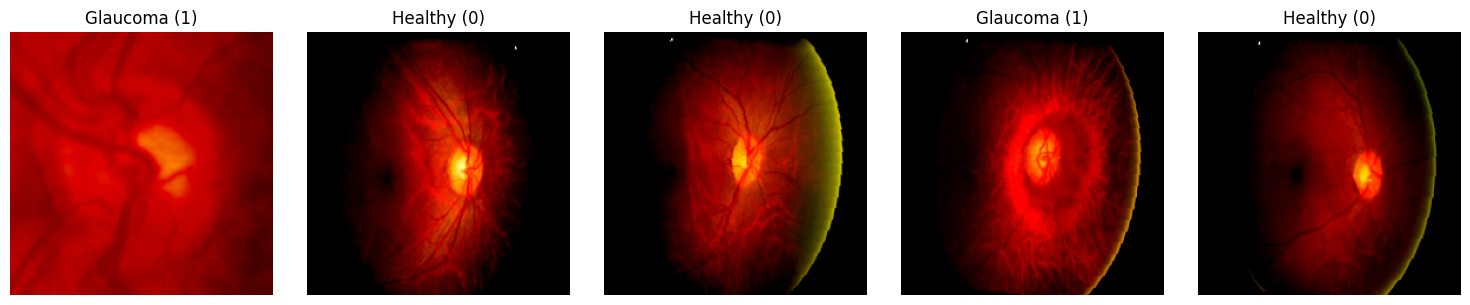

Validation set samples:


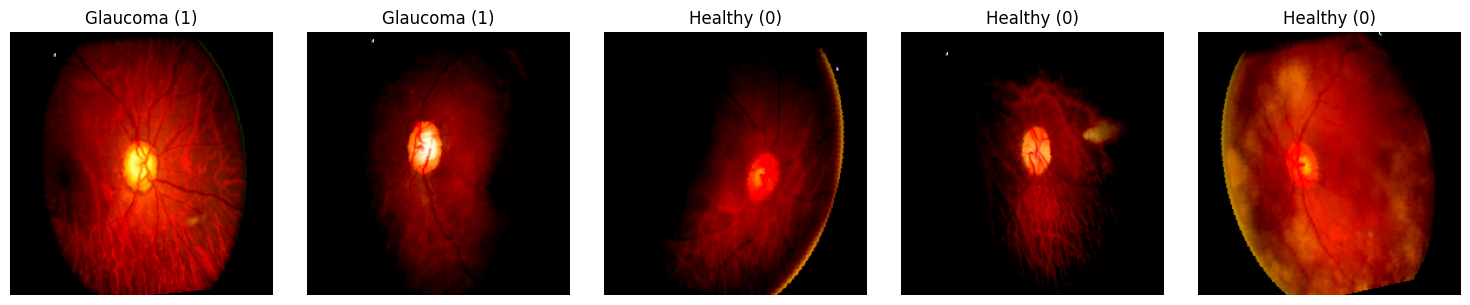

In [5]:
import matplotlib.pyplot as plt
import torch

# Label mapping
classes = ['Healthy (0)', 'Glaucoma (1)']

def show_samples(loader, num_samples=5):
    """
    Display sample RGB images from a DataLoader in a grid.
    """
    images, labels = next(iter(loader))  # get one batch
    num_samples = min(num_samples, len(images))
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu()  # (C, H, W) -> (H, W, C)
        label = labels[i].item()
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show samples from training and validation sets
print("Training set samples:")
show_samples(train_loader, num_samples=5)

print("Validation set samples:")
show_samples(val_loader, num_samples=5)


# Advance AlexNet Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=2, in_channels=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(192),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

# Multi GPU Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2).to(device)

# Use all available GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


Using 2 GPUs


# Training Loop

Using 2 GPUs


/tmp/ipykernel_19/3230997373.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_19/3230997373.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/30] Train Loss: 0.7597, Train Acc: 0.6535 Val Loss: 0.5449, Val Acc: 0.7413
Epoch [2/30] Train Loss: 0.5516, Train Acc: 0.7470 Val Loss: 0.4918, Val Acc: 0.8107
Epoch [3/30] Train Loss: 0.6565, Train Acc: 0.7610 Val Loss: 0.9467, Val Acc: 0.7653
Epoch [4/30] Train Loss: 0.5883, Train Acc: 0.7430 Val Loss: 0.5129, Val Acc: 0.8160
Epoch [5/30] Train Loss: 0.5437, Train Acc: 0.7377 Val Loss: 0.4755, Val Acc: 0.7760
Epoch [6/30] Train Loss: 0.5356, Train Acc: 0.7570 Val Loss: 0.5669, Val Acc: 0.7947
Epoch [7/30] Train Loss: 0.5247, Train Acc: 0.7790 Val Loss: 0.4777, Val Acc: 0.8133
Epoch [8/30] Train Loss: 0.4941, Train Acc: 0.7784 Val Loss: 0.4947, Val Acc: 0.8053
Epoch [9/30] Train Loss: 0.5675, Train Acc: 0.7303 Val Loss: 0.5086, Val Acc: 0.8080
Epoch [10/30] Train Loss: 0.5197, Train Acc: 0.7891 Val Loss: 0.4573, Val Acc: 0.8160
Epoch [11/30] Train Loss: 0.5191, Train Acc: 0.7523 Val Loss: 0.4865, Val Acc: 0.7947
Epoch [12/30] Train Loss: 0.5014, Train Acc: 0.7911 Val Loss: 0

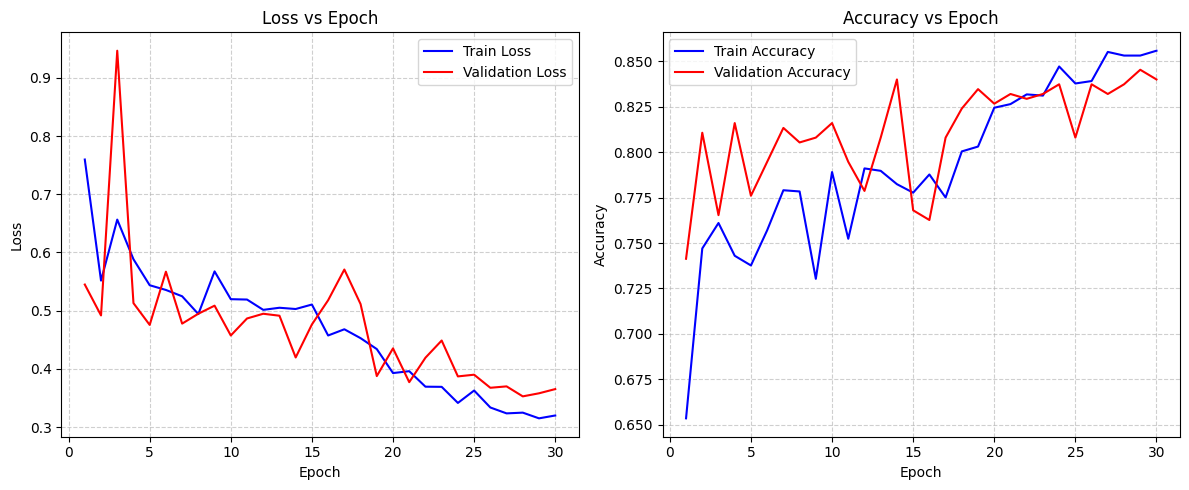

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1️⃣ Device & multi-GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# 2️⃣ Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)  # optional

# 3️⃣ Training parameters
num_epochs = 30

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 4️⃣ Mixed precision scaler (optional for faster GPU training)
scaler = torch.cuda.amp.GradScaler()

# 5️⃣ Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Mixed precision forward
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Scheduler step
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# 6️⃣ Save the model
torch.save(model.state_dict(), "alexnet_glaucoma.pth")
print("✅ Model saved as alexnet_glaucoma.pth")

# 7️⃣ Plot training metrics
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1,num_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1), train_accuracies, 'b-', label='Train Accuracy')
plt.plot(range(1,num_epochs+1), val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# Load & Test Model

✅ Model loaded successfully!
✅ Overall Accuracy: 83.73%

📊 Classification Report:
              precision    recall  f1-score   support

 Healthy (0)       0.82      0.96      0.89       245
Glaucoma (1)       0.89      0.61      0.72       130

    accuracy                           0.84       375
   macro avg       0.85      0.78      0.80       375
weighted avg       0.84      0.84      0.83       375



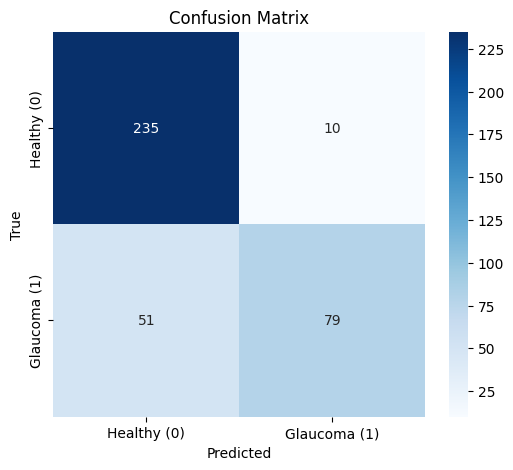

Accuracy for Healthy (0): 95.92%
Accuracy for Glaucoma (1): 60.77%


In [9]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)

# Load state dict safely
state_dict = torch.load("alexnet_glaucoma.pth", map_location=device)
# Remove 'module.' prefix if it exists
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove `module.` prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.eval()

print("✅ Model loaded successfully!")
# 3️⃣ Evaluate on validation/test data
all_preds, all_labels = [], []

with torch.no_grad():
    correct, total = 0, 0
    for images, labels in val_loader:  # replace val_loader with test_loader if available
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# 4️⃣ Overall accuracy
accuracy = correct / total
print(f"✅ Overall Accuracy: {accuracy * 100:.2f}%")

# 5️⃣ Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# 6️⃣ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 7️⃣ Optional: per-class accuracy
cm_diag = np.diag(cm)
class_counts = cm.sum(axis=1)
for i, cls in enumerate(classes):
    print(f"Accuracy for {cls}: {cm_diag[i] / class_counts[i] * 100:.2f}%")


# Visualization on overall and glucoma only

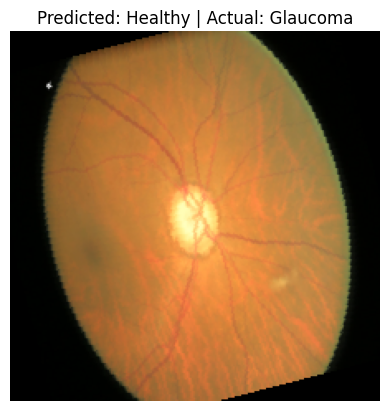

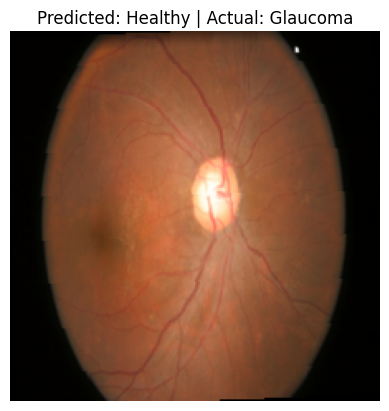

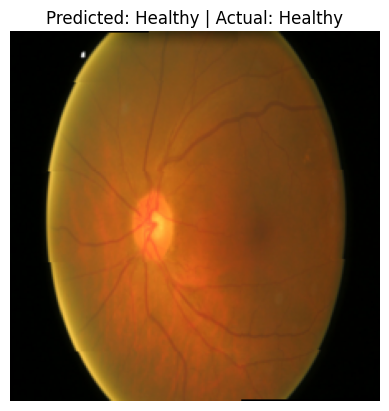

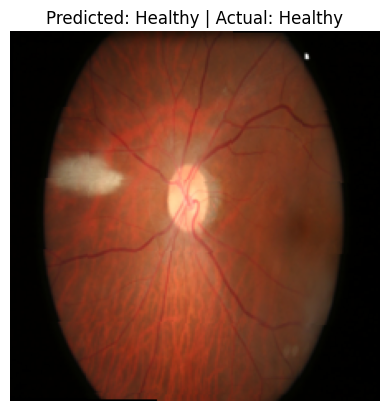

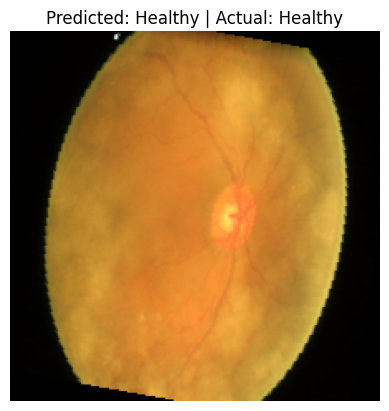


✅ Model Accuracy on this batch: 87.50%


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Define class names
classes = ['Healthy', 'Glaucoma']

# 2️⃣ Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)

state_dict = torch.load("alexnet_glaucoma.pth", map_location=device)

# Remove 'module.' prefix if it exists
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.eval()

# 3️⃣ Function to show image predictions
def imshow(img, title):
    """
    img: Tensor (C,H,W) normalized in [0,1] or [-1,1]
    """
    img = img.permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C
    # If normalized to [-1,1], convert to [0,1]
    if img.min() < 0:
        img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show()

# 4️⃣ Get some random samples from validation/test loader
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 5️⃣ Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# 6️⃣ Display first few predictions visually
for i in range(min(5, images.size(0))):  # show up to 5 images
    img = images[i]
    true_label = classes[labels[i].item()]
    pred_label = classes[preds[i].item()]
    color = "green" if true_label == pred_label else "red"
    imshow(img, title=f"Predicted: {pred_label} | Actual: {true_label}")

# 7️⃣ Overall accuracy on this batch
correct = (preds == labels).sum().item()
total = labels.size(0)
accuracy = 100 * correct / total
print(f"\n✅ Model Accuracy on this batch: {accuracy:.2f}%")



🧠 Glaucoma-Only Accuracy: 61.54%

🔍 Sample Predictions (Glaucoma Cases):


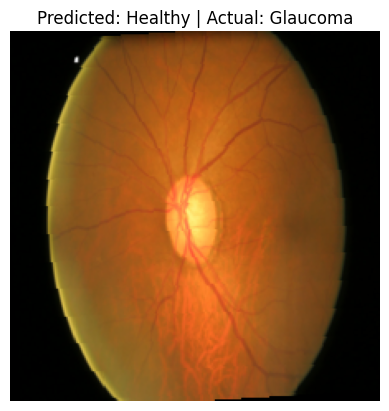

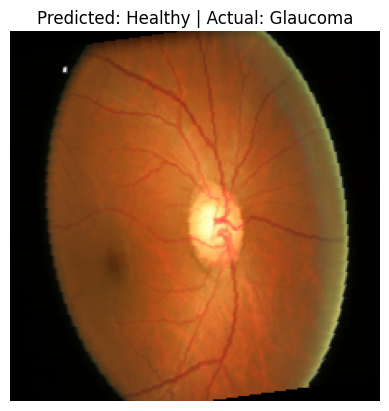

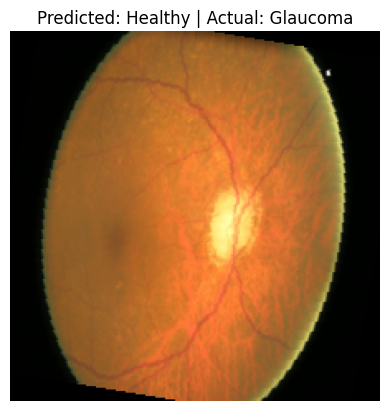

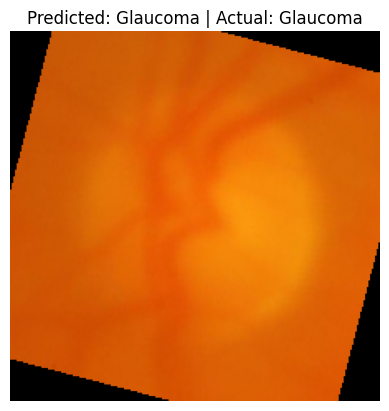

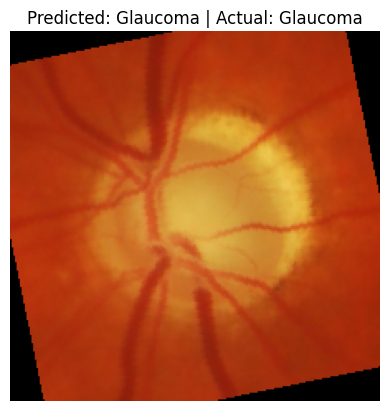

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

classes = ['Healthy', 'Glaucoma']

# 1️⃣ Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)

state_dict = torch.load("alexnet_glaucoma.pth", map_location=device)

# Remove 'module.' prefix if it exists
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.eval()

# 2️⃣ Function to show images
def imshow(img, title):
    """
    img: Tensor (C,H,W) normalized in [-1,1] or [0,1]
    """
    img = img.permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C
    if img.min() < 0:
        img = (img + 1) / 2  # unnormalize if in [-1,1]
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show()

# 3️⃣ Collect all glaucoma samples from validation set
glaucoma_indices = [i for i, (_, label) in enumerate(val_loader.dataset) if label == 1]

correct_glaucoma = 0
total_glaucoma = len(glaucoma_indices)

# 4️⃣ Loop over all glaucoma samples to compute accuracy
for idx in glaucoma_indices:
    image, label = val_loader.dataset[idx]
    image = image.unsqueeze(0).to(device)

    output = model(image)
    _, pred = torch.max(output, 1)

    if pred.item() == 1:
        correct_glaucoma += 1

glaucoma_acc = correct_glaucoma / total_glaucoma * 100
print(f"\n🧠 Glaucoma-Only Accuracy: {glaucoma_acc:.2f}%")

# 5️⃣ Randomly pick 5 glaucoma samples to visualize
sample_indices = random.sample(glaucoma_indices, min(5, len(glaucoma_indices)))

print("\n🔍 Sample Predictions (Glaucoma Cases):")
for idx in sample_indices:
    image, label = val_loader.dataset[idx]
    image = image.unsqueeze(0).to(device)

    output = model(image)
    _, pred = torch.max(output, 1)
    pred_label = classes[pred.item()]
    true_label = classes[label]

    imshow(image.squeeze(0), title=f"Predicted: {pred_label} | Actual: {true_label}")
